# Titanic Survival using Random Forest
Notebook written by Bruno Scheibler

In [509]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [510]:
df = pd.read_csv('train.csv')

In [511]:
X_test = pd.read_csv('test.csv')

In [512]:
total = df.append(X_test,sort=False)

In [513]:
total.drop('Survived',axis=1,inplace=True)

In [514]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [515]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


/Users/Bruno/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Bruno/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Bruno/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


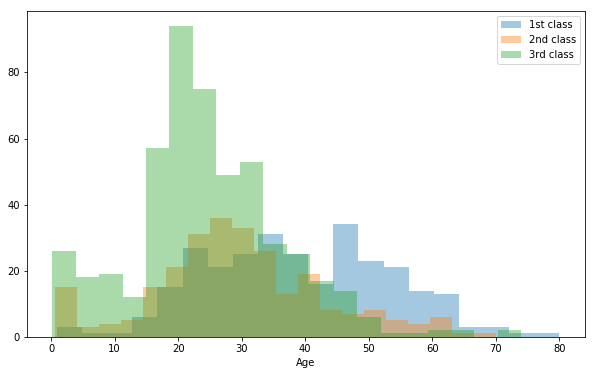

In [516]:
plt.figure(figsize=(10,6))
sns.distplot(total[total['Pclass']==1]['Age'].dropna(),label='1st class',kde=False,bins=20)
sns.distplot(total[total['Pclass']==2]['Age'].dropna(),label='2nd class',kde=False,bins=20)
sns.distplot(total[total['Pclass']==3]['Age'].dropna(),label='3rd class',kde=False,bins=20)
plt.legend()

/Users/Bruno/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Bruno/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


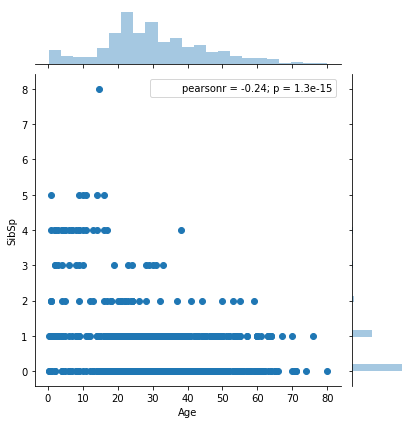

In [517]:
sns.jointplot(x='Age',y='SibSp',data=total)

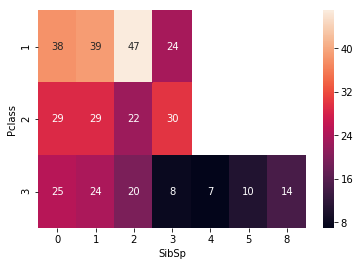

In [518]:
Corr = total[['Pclass','SibSp','Age']]
Corr = Corr.groupby(['Pclass','SibSp'],as_index=False).median()
Corr = Corr.pivot(index='Pclass',columns='SibSp',values='Age')
sns.heatmap(Corr,annot=True)

In [519]:
def fill_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    SibSp = cols[2]
    if pd.isnull(Age):
        return Corr[SibSp][Pclass]
    else:
        return Age

In [520]:
df['Age'] = df[['Age','Pclass','SibSp']].apply(fill_age,axis=1)
X_test['Age'] = X_test[['Age','Pclass','SibSp']].apply(fill_age,axis=1)

In [521]:
Age_Class = total[['Pclass','Age']].groupby('Pclass').median()

In [522]:
def fill_age2(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        return Age_Class.loc[Pclass]
    else:
        return Age

In [523]:
df['Age'] = df[['Age','Pclass']].apply(fill_age2,axis=1)
X_test['Age'] = X_test[['Age','Pclass']].apply(fill_age2,axis=1)

In [524]:
df[df['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [525]:
X_test[X_test['Age'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [526]:
df.drop('Cabin',axis=1,inplace=True)
X_test.drop('Cabin',axis=1,inplace=True)

In [527]:
df.dropna(inplace=True)

In [528]:
Ticket = pd.DataFrame(total['Ticket'].str.split(' ',1).tolist(),columns = ['A','B'])

In [529]:
Ticket_string = Ticket[Ticket['B'].isnull()==False]['A']

In [530]:
import string

In [531]:
def remove_punctuations(ticket):
    nopunc = [char for char in ticket if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return nopunc.upper()

In [532]:
Ticket_string = Ticket_string.apply(remove_punctuations)

In [533]:
total['Ticket']=Ticket_string

In [534]:
def get_dummies(column):
    global total
    global df
    global X_test
    tmp_column = pd.get_dummies(total[column],drop_first=True)
    total.drop(column,axis=1,inplace=True)
    df.drop(column,axis=1,inplace=True)
    X_test.drop(column,axis=1,inplace=True)
    
    total  = pd.concat([total,tmp_column],axis=1)
    df     =     df.join(total.set_index('PassengerId').loc[:,str(tmp_column.columns[0]):str(tmp_column.columns[-1])])
    X_test = X_test.join(total.set_index('PassengerId').loc[:,str(tmp_column.columns[0]):str(tmp_column.columns[-1])])

In [535]:
def class_to_string(Pclass):
    classes = {1:'first',2:'second',3:'third'}
    return classes[Pclass]

In [536]:
total['Pclass'] = total['Pclass'].apply(class_to_string)

In [537]:
df     =     df.set_index('PassengerId')
X_test = X_test.set_index('PassengerId')
get_dummies('Ticket')
get_dummies('Sex')
get_dummies('Embarked')
get_dummies('Pclass')

In [538]:
df.dropna(inplace=True)

In [539]:
X_train = df.drop(['Survived','Name'],axis=1)
X_test.drop(['Name'],axis=1,inplace=True)

In [540]:
X_test.isnull().any()

Age        False
SibSp      False
Parch      False
Fare        True
A5         False
AS         False
C          False
CA         False
CASOTON    False
FA         False
FC         False
FCC        False
PC         False
PP         False
PPP        False
SC         False
SCA4       False
SCAH       False
SCOW       False
SCPARIS    False
SOC        False
SOP        False
SOPP       False
SOTONO2    False
SOTONOQ    False
SP         False
STONO      False
STONO2     False
SWPP       False
WC         False
WEP        False
male       False
Q          False
S          False
second     False
third      False
dtype: bool

In [543]:
X_test[X_test.isnull().T.any().T]

,Age,SibSp,Parch,Fare,A5,AS,C,CA,CASOTON,FA,...,STONO,STONO2,SWPP,WC,WEP,male,Q,S,second,third
PassengerId,,,,,,,,,,,,,,,,,,,,,
1044,60.5,0,0,NaN,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1


In [544]:
ThirdClassFare = X_test[X_test['third']==1]['Fare']

In [545]:
X_test['Fare'] = X_test['Fare'].map(lambda x: ThirdClassFare.median() if pd.isnull(x) else x)

In [546]:
y_train = df['Survived']

In [547]:
from sklearn.ensemble import RandomForestClassifier

In [548]:
random_forest = RandomForestClassifier(n_estimators=1000)

In [549]:
random_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [550]:
predictions = random_forest.predict(X_test)

In [551]:
Answer=pd.DataFrame(data=X_test.index.values)
Answer['Survived'] = predictions
Answer.columns = ['PassengerId','Survived']
Answer.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


In [552]:
Answer.to_csv('Titanic_Answer_Random_Forest.csv',index=False)